# SETUP

### IMPORTS

In [30]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

import duckdb as ddb
ddb.connect('duck.db')

### TABLE SETUP

In [31]:
tables = [table[0] for table in ddb.execute('SHOW TABLES').fetchall()]
if 'results' not in tables:
    ddb.execute('CREATE TABLE IF NOT EXISTS results (player_id TINYINT, rank TINYINT)')
if 'players' not in tables:
    ddb.execute('CREATE TABLE IF NOT EXISTS players (player_id TINYINT PRIMARY KEY, player_name VARCHAR(100))')
    q = '''
        INSERT INTO players (player_id, player_name) 
        VALUES
            (1, 'el_grande_ballers'),
            (2, 'its_a_beaut_clark'),
            (3, 'best_money_can_buy'),
            (4, 'brodys_boss_team'),
            (5, 'hell_on_heels'),
            (6, 'tingleman'),
            (7, 'bogey_max'),
            (8, 'hot_garbage'),
            (9, 'franchise'),
            (10, 'mac_attack'),
            (11, 'rebel_alliance'),
            (12, 'dave_ramsey')
    '''
    ddb.execute(q)

### SIMULATION FUNCTIONS

In [32]:
def play_game(player0, player1):
    sample0 = np.random.normal(loc=player0['mean'], scale=player0['stdev'], size=1)[0]
    sample1 = np.random.normal(loc=player1['mean'], scale=player1['stdev'], size=1)[0]
    if sample0 >= sample1: 
        player0['wins']+=1
        player0['points']+=int(sample0)
        player1['points']+=int(sample1)
    else:
        player1['wins']+=1
        player0['points']+=int(sample0)
        player1['points']+=int(sample1)

def rigged_game(player0, player0_score, player1, player1_score):
    if player0_score >= player1_score: 
        player0['wins']+=1
        player0['points']+=int(player0_score)
        player1['points']+=int(player1_score)
    else:
        player1['wins']+=1
        player0['points']+=int(player0_score)
        player1['points']+=int(player1_score)

def simulate(runs=1000000):
    ddb.execute('TRUNCATE TABLE results')
    results = []
    for x in range(runs):
        # CREATE THE PLAYERS
        players = {
            1: {'player_name': 'el_grande_ballers', 'wins': 8, 'points': 1223, 'mean': 99, 'stdev': 25},
            2: {'player_name': 'its_a_beaut_clark', 'wins': 8, 'points': 1154, 'mean': 94, 'stdev': 15},
            3: {'player_name': 'best_money_can_buy', 'wins': 7, 'points': 1252, 'mean': 104, 'stdev': 25},
            4: {'player_name': 'brodys_boss_team', 'wins': 7, 'points': 1075, 'mean': 89, 'stdev': 15},
            5: {'player_name': 'hell_on_heels', 'wins': 6, 'points': 1184, 'mean': 98, 'stdev': 21},
            6: {'player_name': 'tingleman', 'wins': 6, 'points': 1123, 'mean': 93, 'stdev': 12},
            7: {'player_name': 'bogey_max', 'wins': 6, 'points': 1069, 'mean': 89, 'stdev': 27},
            8: {'player_name': 'hot_garbage', 'wins': 6, 'points': 1060, 'mean': 88, 'stdev': 19},
            9: {'player_name': 'franchise', 'wins': 5, 'points': 1108, 'mean': 92, 'stdev': 17},
            10: {'player_name': 'mac_attack', 'wins': 5, 'points': 1090, 'mean': 90, 'stdev': 15},
            11: {'player_name': 'rebel_alliance', 'wins': 5, 'points': 1023, 'mean': 85, 'stdev': 17},
            12: {'player_name': 'dave_ramsey', 'wins': 3, 'points': 1003, 'mean': 83, 'stdev': 18}
        }

        # WEEK 1
        play_game(players[4], players[10])  # brodys_boss_team vs mac_attack
        #rigged_game(players[4], 88, players[10], 95)
        play_game(players[9], players[1])  # franchise vs el_grande_ballers
        play_game(players[2], players[11]) # its_a_beaut_clark vs rebel_alliance
        play_game(players[8], players[6])  # hot_garbage vs tingleman
        play_game(players[5], players[12]) # hell_on_heels vs dave_ramsey
        play_game(players[7], players[3])  # bogey_max vs best_money_can_buy

        # WEEK 2
        play_game(players[4], players[2])  # brodys_boss_team vs its_a_beaut_clark
        play_game(players[7], players[1])  # bogey_max vs el_grande_ballers
        play_game(players[8], players[3])  # hot_garbage vs best_money_can_buy
        play_game(players[10], players[5]) # mac_attack vs hell_on_heels
        play_game(players[6], players[11]) # tingleman vs rebel_alliance
        play_game(players[9], players[12]) # franchise vs dave_ramsey

        # RANK TEAMS
        sorted_teams = sorted(players.items(), key=lambda x: (-x[1]['wins'], -x[1]['points']))
        
        # GET RANK OF TEAM OF INTEREST
        for z in range(len(sorted_teams)):
            tup = (sorted_teams[z][0], z+1)
            results.append(tup)
    df = pd.DataFrame(results, columns=['player_id', 'rank'])
    ddb.execute('INSERT INTO results (player_id, rank) SELECT player_id, rank FROM df')



In [33]:
results = simulate(runs=1000000)

# RESULTS

### PLAYOFF ODDS

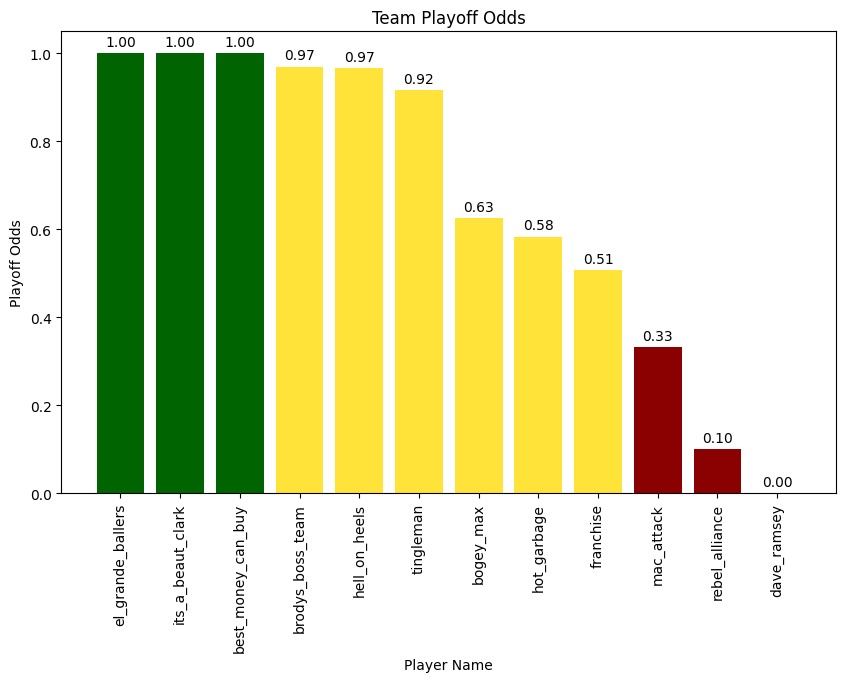

In [35]:
q = f'''
    WITH stats AS (
        SELECT
            player_id,
            COUNT(CASE WHEN rank <= 8 THEN 1 ELSE NULL END) / (SELECT COUNT(*) FROM results WHERE player_id = r.player_id) AS "Playoff Odds" 
        FROM results r
        GROUP BY player_id
        ORDER BY player_id
    )
    SELECT
        p.player_name,
        "Playoff Odds"
    FROM stats s
    INNER JOIN players p ON s.player_id = p.player_id
    ORDER BY "Playoff Odds" DESC
'''
df = ddb.execute(q).fetchdf()

def assign_colors(playoff_odds):
    if playoff_odds == 1:
        return '#006400'  # Green for odds = 1
    elif playoff_odds >= 0.5:
        return '#ffe338'  # Yellow for odds > 0.5
    else:
        return '#8b0000'  # Red for odds < 0.5

colors = df['Playoff Odds'].apply(assign_colors)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(df['player_name'], df['Playoff Odds'], color=colors)

for bar in bars:
    yval = bar.get_height()  # Get the height of the bar
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
        yval + 0.01,  # Y position (slightly above the top of the bar)
        f'{yval:.2f}',  # Display the value with 2 decimal places
        ha='center',  # Horizontal alignment to center the text
        va='bottom',  # Vertical alignment to position text just above the bar
        fontsize=10,  # Font size of the label
        color='black'  # Color of the label
    )

plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Player Name')
plt.ylabel('Playoff Odds')
plt.title('Team Playoff Odds')

# Show the plot
plt.show()